In [1]:
import os
import sys

sys.path.append("/home/yuri/github.com/AoesJP/project_pokereader")
sys.path

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pickle

In [3]:
from pokedex.edges import deformer, draw

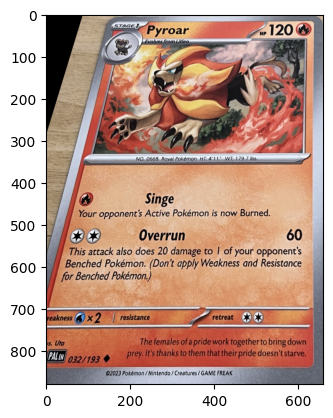

In [28]:
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/IMG_1488.jpeg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/IMG_1498.jpeg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/swsh12pt5-62.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/dv1-2.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/charizard2.png"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/pika.jpeg"
img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/poke1.png"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/poke2.png"
deformed_img = deformer.deform_card(img_path)
draw.show_color(deformed_img)

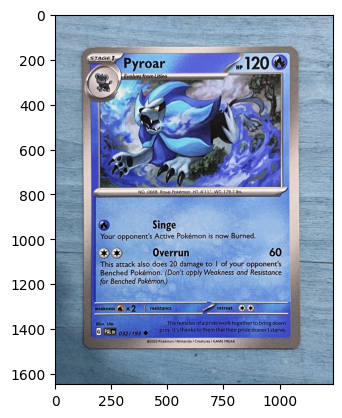

In [29]:
img_orig = cv2.imread(img_path)
draw.show_color(img_orig)

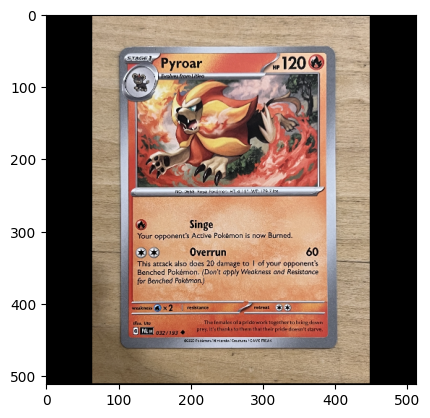

In [30]:
IMG_SIZE = (512, 512)
img = deformer.resize_with_fill(
    cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), IMG_SIZE[0], IMG_SIZE[1]
)
draw.show_color(img)

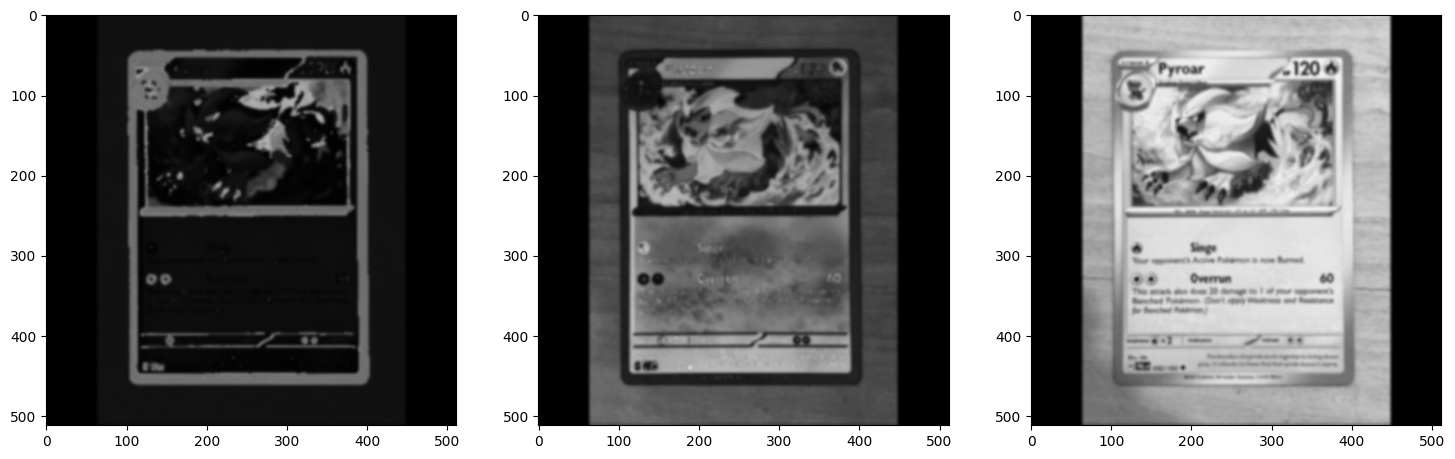

In [31]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
# blurred_rgb = cv2.GaussianBlur(img, (9, 9), 0)
blurred_hsv = cv2.GaussianBlur(img_hsv, (9, 9), 0)
draw.show_channels(blurred_hsv)

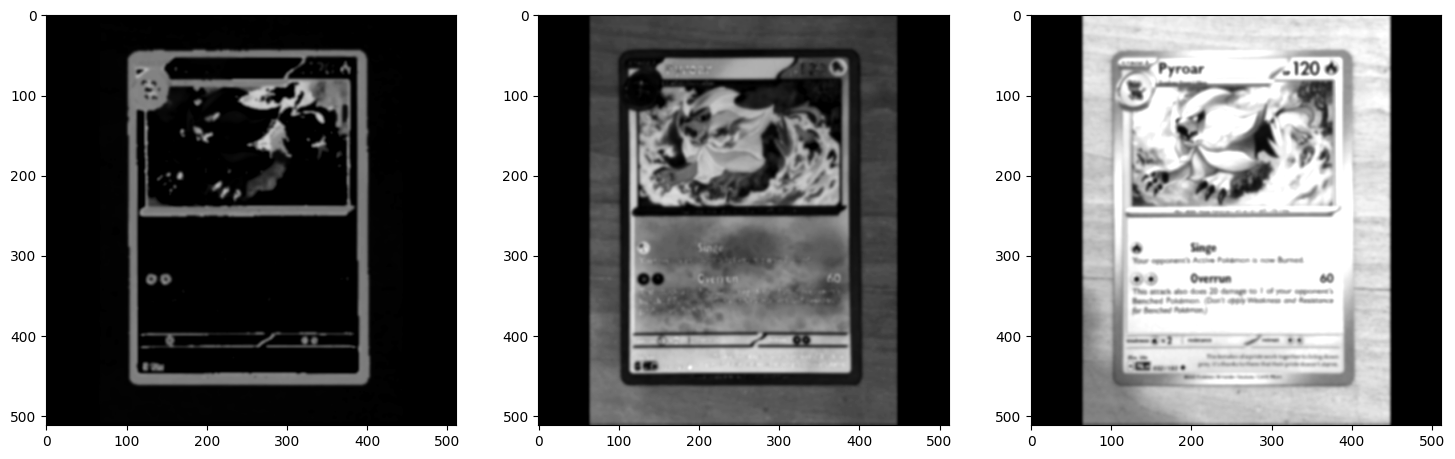

In [32]:
alpha = 1.3
beta = -20
img_h = deformer.apply_contrast(blurred_hsv[:, :, 0], alpha=alpha, beta=beta)
img_s = deformer.apply_contrast(blurred_hsv[:, :, 1], alpha=alpha, beta=beta)
img_v = deformer.apply_contrast(blurred_hsv[:, :, 2], alpha=alpha, beta=beta)
draw.show_channels(np.stack([img_h, img_s, img_v], axis=2))

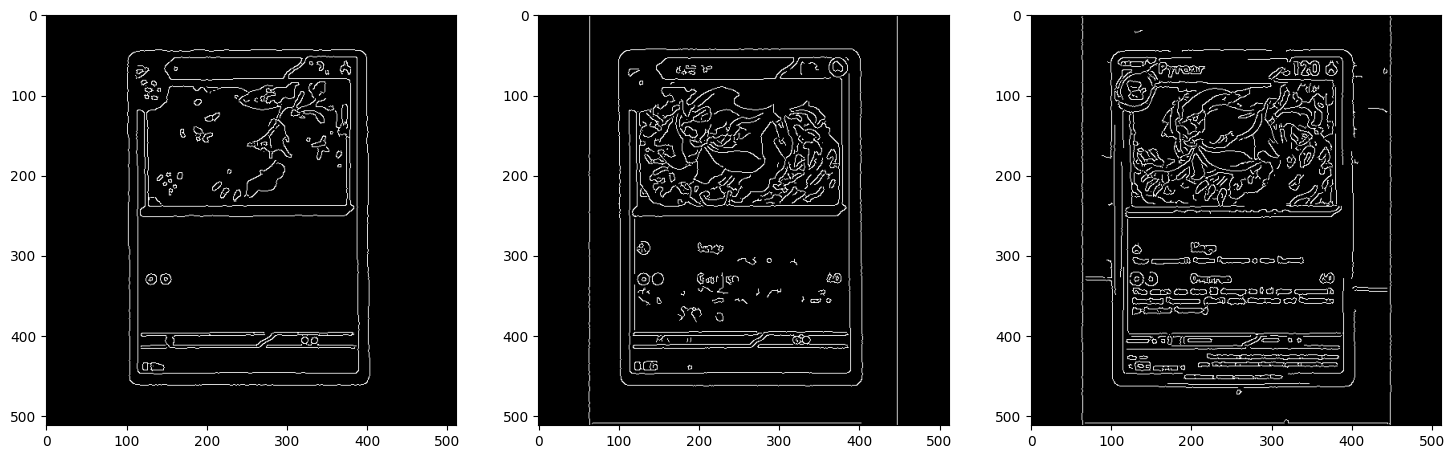

In [33]:
edge1 = cv2.Canny(img_h, 50, 100)
edge2 = cv2.Canny(img_s, 50, 100)
edge3 = cv2.Canny(img_v, 50, 100)
draw.show_channels(np.stack([edge1, edge2, edge3], axis=2))

In [34]:
# edge_all = cv2.max(cv2.max(edge1, edge2), edge3)

# draw.show_grey(edge_all)

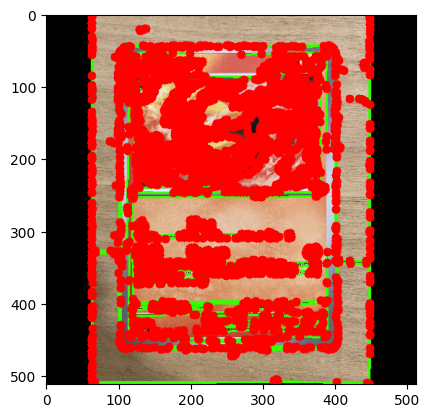

In [35]:
contours_all = []
contours, hierarchy = cv2.findContours(edge1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(contours))
contours, hierarchy = cv2.findContours(edge2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(contours))
contours, hierarchy = cv2.findContours(edge3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(contours))
draw.draw_contours(img, contours_all)

In [36]:
# contours, hierarchy = cv2.findContours(edge_all, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
# list(contours)

In [37]:
contours = contours_all

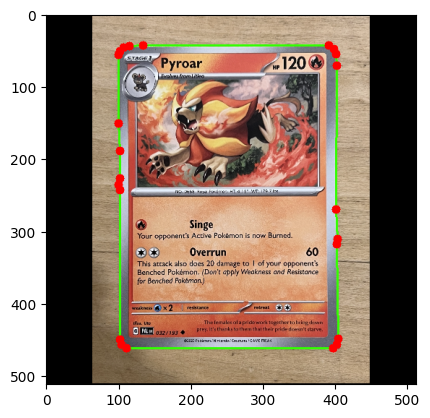

In [38]:
cnt_smoothed = deformer.smooth_contours(contours, epsilon=1)
cnt_smoothed_cleaned = deformer.remove_short_contours(cnt_smoothed)
found_contours = deformer.find_rectangle_contours(cnt_smoothed_cleaned, deformer.base_contour)
if not len(found_contours) > 0:
    deformer.logger.warning("No contour was found. Exiting.")

best_fit_contour = found_contours[0][0]
draw.draw_contour(img, best_fit_contour)

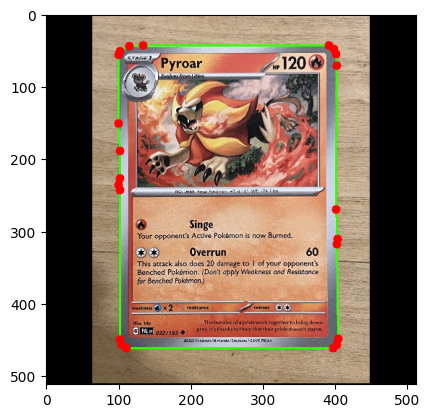

In [39]:
best_fit_contour = deformer.remove_flat_points(best_fit_contour, threshold=2)
draw.draw_contour(img, best_fit_contour)

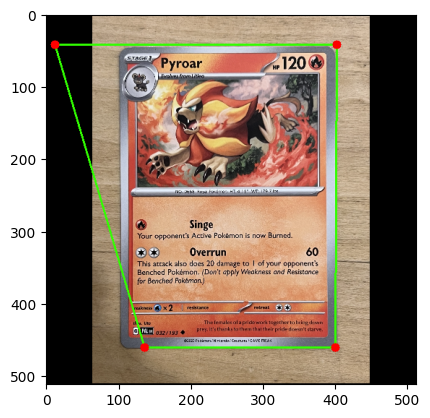

In [40]:
best_fit_contour = deformer.get_corners_from_contour(best_fit_contour)
draw.draw_contour(img, best_fit_contour)